### Backtrader多数据画图

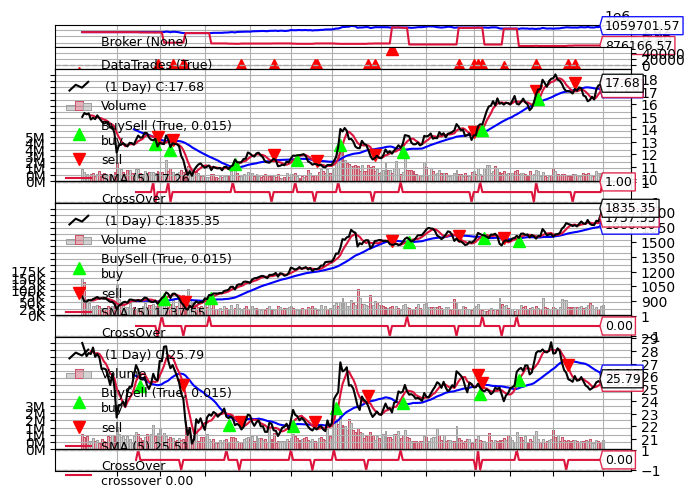

1059701.5694999998


In [ ]:
from datetime import datetime
import backtrader as bt
import pandas as pd
import efinance
import matplotlib.pyplot as plt
plt.style.use('default')


def get_k_data(stock_code, begin: datetime, end: datetime) -> pd.DataFrame:
    """根据efinance工具包获取股票数据
    :param stock_code:股票代码
    :param begin: 开始日期
    :param end: 结束日期
    """
    # stock_code = '600519'  # 股票代码，茅台
    k_dataframe: pd.DataFrame = efinance.stock.get_quote_history(
        stock_code, beg=begin.strftime("%Y%m%d"), end=end.strftime("%Y%m%d"))
    k_dataframe = k_dataframe.iloc[:, :9]
    k_dataframe.columns = ['name', 'code', 'date', 'open', 'close', 'high', 'low', 'volume', 'turnover']
    k_dataframe.index = pd.to_datetime(k_dataframe.date)
    k_dataframe.drop(['name', 'code', "date"], axis=1, inplace=True)
    return k_dataframe


class SmaCross(bt.SignalStrategy):
    def __init__(self):
        sma1, sma2 = bt.ind.SMA(period=10), bt.ind.SMA(period=30)
        crossover = bt.ind.CrossOver(sma1, sma2)
        self.signal_add(bt.SIGNAL_LONG, crossover)


class MultiSMACrossStrategy(bt.Strategy):
    params = (
        ('fast_length', 5),
        ('slow_length', 25)
    )
     
    def __init__(self):
        self.crossovers = []
         
        for d in self.datas: 
            ma_fast = bt.ind.SMA(d, period = self.params.fast_length)
            ma_slow = bt.ind.SMA(d, period = self.params.slow_length)
 
            self.crossovers.append(bt.ind.CrossOver(ma_fast, ma_slow))
 
    def next(self):
        for i, d in enumerate(self.datas):
            if not self.getposition(d).size:
                if self.crossovers[i] > 0: 
                    self.buy(data = d, size=100)
            elif self.crossovers[i] < 0: 
                if self.getposition(d).size > 0:
                    self.close(data = d)


if __name__ == '__main__':
    # 获取数据
    start_time = datetime(2020, 1, 1)
    end_time = datetime(2021, 1, 1)
    cerebro = bt.Cerebro()
    dataframe = get_k_data('000001', begin=start_time, end=end_time)
    data = bt.feeds.PandasData(dataname=dataframe, fromdate=start_time, todate=end_time)
    cerebro.adddata(data)
    dataframe = get_k_data('600519', begin=start_time, end=end_time)
    data = bt.feeds.PandasData(dataname=dataframe, fromdate=start_time, todate=end_time)
    cerebro.adddata(data)
    dataframe = get_k_data('000002', begin=start_time, end=end_time)
    data = bt.feeds.PandasData(dataname=dataframe, fromdate=start_time, todate=end_time)
    cerebro.adddata(data)
    cerebro.addstrategy(MultiSMACrossStrategy)
    start_cash = 1000000
    cerebro.broker.setcash(start_cash)
    cerebro.broker.setcommission(commission=0.00025)
    cerebro.run()
    cerebro.plot(iplot=False)

    print(cerebro.runstrats[0])
    print(cerebro.broker.getvalue())

### Sko优化demo

In [3]:
from datetime import datetime
import backtrader as bt
import pandas as pd
import efinance
import optuna

def get_k_data(stock_code, begin: datetime, end: datetime) -> pd.DataFrame:
    """根据efinance工具包获取股票数据
    :param stock_code:股票代码
    :param begin: 开始日期
    :param end: 结束日期
    """
    # stock_code = '600519'  # 股票代码，茅台
    k_dataframe: pd.DataFrame = efinance.stock.get_quote_history(
        stock_code, beg=begin.strftime("%Y%m%d"), end=end.strftime("%Y%m%d"))
    k_dataframe = k_dataframe.iloc[:, :9]
    k_dataframe.columns = ['name', 'code', 'date', 'open', 'close', 'high', 'low', 'volume', 'turnover']
    k_dataframe.index = pd.to_datetime(k_dataframe.date)
    k_dataframe.drop(['name', 'code', "date"], axis=1, inplace=True)
    return k_dataframe


class SmaCross(bt.SignalStrategy):
    params = (('period1', 10),
              ('period2', 30),
              )

    def __init__(self):
        sma1, sma2 = bt.ind.SMA(period=self.p.period1), bt.ind.SMA(period=self.p.period2)
        crossover = bt.ind.CrossOver(sma1, sma2)
        self.signal_add(bt.SIGNAL_LONG, crossover)


start_time = datetime(2020, 1, 1)
end_time = datetime(2021, 1, 1)
dataframe = get_k_data('600519', begin=start_time, end=end_time)
# =============== 为系统注入数据 =================
# 加载数据
data = bt.feeds.PandasData(dataname=dataframe, fromdate=start_time, todate=end_time)


def backtest(p) -> float:
    p1, p2 = p
    strategy = SmaCross
    cerebro = bt.Cerebro()
    cerebro.adddata(data)
    cerebro.addstrategy(strategy, period1=int(p1), period2=int(p2))
    start_cash = 1000000
    cerebro.broker.setcash(start_cash)
    cerebro.broker.setcommission(commission=0.00025)
    cerebro.run()
    print(-(start_cash - cerebro.broker.getvalue()))
    return -(start_cash - cerebro.broker.getvalue())

from sko.GA import GA
ga = GA(func=backtest, n_dim=2, size_pop=10, max_iter=100, prob_mut=0.001, lb=[1, 1], ub=[50, 50], precision=1e-7)
best_x, best_y = ga.run()
print('best_x:', best_x, '\n', 'best_y:', best_y)

# from sko.DE import DE
# de = DE(func=backtest, n_dim=2, size_pop=10, max_iter=100, lb=[1, 1], ub=[50, 50])
# best_x, best_y = de.run()
# print('best_x:', best_x, '\n', 'best_y:', best_y)

# from sko.PSO import PSO
# pso = PSO(func=backtest, n_dim=2, pop=10, max_iter=100, lb=[1, 1], ub=[50, 50], w=0.8, c1=0.5, c2=0.5)
# pso.run()
# print('best_x is ', pso.gbest_x, 'best_y is', pso.gbest_y)

717.9925924999407
790.9055874999613
775.1515250001103
470.4706025000196
749.7098799999803
62.39658499986399
464.1561275002314
404.0569100001594
352.9531649998389
882.8864149998408
62.39658499986399
352.9531649998389
323.110232500243
470.4706025000196
62.39658499986399
62.39658499986399
464.1561275002314
29.243825000012293
470.4706025000196
62.39658499986399
62.39658499986399
62.39658499986399
358.14446249988396
527.2655675001442
352.9531649998389
29.243825000012293
62.39658499986399
23.235327500035055
305.8434399998514
29.243825000012293
62.39658499986399
62.39658499986399
62.39658499986399
62.39658499986399
23.235327500035055
62.39658499986399
29.243825000012293
62.39658499986399
23.235327500035055
29.243825000012293
29.243825000012293
23.235327500035055
23.235327500035055
23.235327500035055
29.243825000012293
23.235327500035055
62.39658499986399
23.235327500035055
62.39658499986399
23.235327500035055
23.235327500035055
23.235327500035055
23.235327500035055
23.235327500035055
23.23532

### Optuna优化接口

In [16]:
from datetime import datetime
import backtrader as bt
import pandas as pd
import efinance
import optuna

def get_k_data(stock_code, begin: datetime, end: datetime) -> pd.DataFrame:
    """根据efinance工具包获取股票数据
    :param stock_code:股票代码
    :param begin: 开始日期
    :param end: 结束日期
    """
    # stock_code = '600519'  # 股票代码，茅台
    k_dataframe: pd.DataFrame = efinance.stock.get_quote_history(
        stock_code, beg=begin.strftime("%Y%m%d"), end=end.strftime("%Y%m%d"))
    k_dataframe = k_dataframe.iloc[:, :9]
    k_dataframe.columns = ['name', 'code', 'date', 'open', 'close', 'high', 'low', 'volume', 'turnover']
    k_dataframe.index = pd.to_datetime(k_dataframe.date)
    k_dataframe.drop(['name', 'code', "date"], axis=1, inplace=True)
    return k_dataframe


class SmaCross(bt.SignalStrategy):
    params = (('period1', 10),
              ('period2', 30),
              )

    def __init__(self):
        sma1, sma2 = bt.ind.SMA(period=self.p.period1), bt.ind.SMA(period=self.p.period2)
        crossover = bt.ind.CrossOver(sma1, sma2)
        self.signal_add(bt.SIGNAL_LONG, crossover)


start_time = datetime(2020, 1, 1)
end_time = datetime(2021, 1, 1)
dataframe = get_k_data('600519', begin=start_time, end=end_time)
data = bt.feeds.PandasData(dataname=dataframe, fromdate=start_time, todate=end_time)


def backtest(trial) -> float:
    p1 = trial.suggest_int("p1", 1, 50)
    p2 = trial.suggest_int("p2", 1, 50)
    strategy = SmaCross
    cerebro = bt.Cerebro()
    cerebro.adddata(data)
    cerebro.addstrategy(strategy, period1=int(p1), period2=int(p2))
    start_cash = 1000000
    cerebro.broker.setcash(start_cash)
    cerebro.broker.setcommission(commission=0.00025)
    cerebro.run()
    return start_cash - cerebro.broker.getvalue()


study = optuna.create_study(direction='maximize')
study.optimize(backtest, n_trials=10, n_jobs=1)
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: {}".format(trial.params))

[I 2025-03-17 03:00:37,194] A new study created in memory with name: no-name-51e21f0f-3189-4be9-8cf8-88b8923a5f51
[I 2025-03-17 03:00:37,290] Trial 0 finished with value: -544.6457574999658 and parameters: {'p1': 29, 'p2': 35}. Best is trial 0 with value: -544.6457574999658.
[I 2025-03-17 03:00:37,366] Trial 1 finished with value: -117.31436249997932 and parameters: {'p1': 48, 'p2': 15}. Best is trial 1 with value: -117.31436249997932.
[I 2025-03-17 03:00:37,424] Trial 2 finished with value: 1.5688699999591336 and parameters: {'p1': 47, 'p2': 29}. Best is trial 2 with value: 1.5688699999591336.
[I 2025-03-17 03:00:37,488] Trial 3 finished with value: -376.32592750003096 and parameters: {'p1': 20, 'p2': 5}. Best is trial 2 with value: 1.5688699999591336.
[I 2025-03-17 03:00:37,551] Trial 4 finished with value: -89.40133000013884 and parameters: {'p1': 37, 'p2': 35}. Best is trial 2 with value: 1.5688699999591336.
[I 2025-03-17 03:00:37,616] Trial 5 finished with value: -609.110332500073

	Best Score: 60.418877499876544
	Best Params: {'p1': 38, 'p2': 34}


### Backtrader带log记录版本

In [1]:
import backtrader
from loguru import logger
import pandas as pd
import efinance
from datetime import datetime, timedelta


def get_k_data(stock_code, begin: datetime, end: datetime) -> pd.DataFrame:
    """
    根据efinance工具包获取股票数据
    :param stock_code:股票代码
    :param begin: 开始日期
    :param end: 结束日期
    :return:
    """
    # stock_code = '600519'  # 股票代码，茅台
    k_dataframe: pd.DataFrame = efinance.stock.get_quote_history(
        stock_code, beg=begin.strftime("%Y%m%d"), end=end.strftime("%Y%m%d"))
    k_dataframe = k_dataframe.iloc[:, :9]
    k_dataframe.columns = ['name', 'code', 'date', 'open', 'close', 'high', 'low', 'volume', 'turnover']
    k_dataframe.index = pd.to_datetime(k_dataframe.date)
    k_dataframe.drop(['name', 'code', 'date'], axis=1, inplace=True)
    return k_dataframe


class MyStrategy1(backtrader.Strategy):  # 策略
    def __init__(self):
        # 初始化交易指令、买卖价格和手续费
        self.close_price = self.datas[0].close  # 这里加一个数据引用，方便后续操作
        self.sma = backtrader.indicators.SimpleMovingAverage(self.datas[0], period=5)  # 借用这个策略，计算5日的均线
        self.order_list = []

    def notify_order(self, order):  # 固定写法，查看订单情况
        # 查看订单情况
        if order.status in [order.Submitted, order.Accepted]:  # 接受订单交易，正常情况
            return
        if order.status in [order.Completed]:
            if order.isbuy():
                logger.debug('{} 已买入, 购入金额 {} 手续费 {}', order.ref, order.executed.value, order.executed.comm)
            elif order.issell():
                logger.debug('{} 已卖出, 卖出金额 {} 手续费 {}', order.ref, order.executed.value, order.executed.comm)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            logger.debug('{} 订单取消、保证金不足、金额不足拒绝交易', order.ref)
        elif order.status in [order.Expired]:
            logger.debug("订单 {} 超过时效，已取消", order.ref)

    def next(self):  # 固定的函数，框架执行过程中会不断循环next()，过一个K线，执行一次next()
        if self.close_price[0] > self.sma[0]:
            # 执行买入
            # 获得默认的保证金：self.broker.comminfo[None].p.commission
            order = self.buy(size=500, price=self.data.close[0],
                             exectype=backtrader.Order.Limit, valid=timedelta(days=1))
            logger.debug('订单：买 {} ', order.ref)
            self.order_list.append(order)
        # 执行卖出条件已有持仓，且收盘价格跌破5日均线
        if self.position:
            if self.close_price[0] < self.sma[0]:
                # 执行卖出
                order = self.sell(size=500, price=self.data.close[0], exectype=backtrader.Order.Limit,
                                  valid=timedelta(days=1))
                logger.debug('订单：卖 {} ', order.ref)
                self.order_list.append(order)


if __name__ == '__main__':
    # 获取数据
    start_time = datetime(2020, 1, 1)
    end_time = datetime(2021, 1, 1)
    dataframe = get_k_data('600519', begin=start_time, end=end_time)
    # =============== 为系统注入数据 =================
    # 加载数据
    data = backtrader.feeds.PandasData(dataname=dataframe, fromdate=start_time, todate=end_time)
    # 初始化cerebro回测系统
    cerebral_system = backtrader.Cerebro()  # Cerebro引擎在后台创建了broker(经纪人)实例，系统默认每个broker的初始资金量为10000
    # 将数据传入回测系统
    cerebral_system.adddata(data)  # 导入数据，在策略中使用 self.datas 来获取数据源
    # 将交易策略加载到回测系统中
    cerebral_system.addstrategy(MyStrategy1)
    # =============== 系统设置 ==================
    # 设置启动资金为 100000
    start_cash = 1000000
    cerebral_system.broker.setcash(start_cash)
    # 设置手续费 万2.5
    cerebral_system.broker.setcommission(commission=0.00025)
    logger.debug('初始资金: {} 回测期间：from {} to {}'.format(start_cash, start_time, end_time))
    # 运行回测系统
    cerebral_system.run()
    # 获取回测结束后的总资金
    portvalue = cerebral_system.broker.getvalue()
    pnl = portvalue - start_cash
    # 打印结果
    logger.debug('净收益: {}', pnl)
    logger.debug("总资金: {}", portvalue)


/home/renjunji_2023/miniconda3/envs/backtrader/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-17 14:27:57.132 | DEBUG    | __main__:<module>:85 - 初始资金: 1000000 回测期间：from 2020-01-01 00:00:00 to 2021-01-01 00:00:00
2025-02-17 14:27:57.162 | DEBUG    | __main__:next:53 - 订单：买 1 
2025-02-17 14:27:57.163 | DEBUG    | __main__:notify_order:39 - 1 已买入, 购入金额 461510.0 手续费 115.3775
2025-02-17 14:27:57.164 | DEBUG    | __main__:next:53 - 订单：买 2 
2025-02-17 14:27:57.165 | DEBUG    | __main__:notify_order:45 - 订单 2 超过时效，已取消
2025-02-17 14:27:57.166 | DEBUG    | __main__:next:53 - 订单：买 3 
2025-02-17 14:27:57.167 | DEBUG    | __main__:notify_order:39 - 3 已买入, 购入金额 472260.0 手续费 118.065
2025-02-17 14:27:57.168 | DEBUG    | __main__:next:53 - 订单：买 4 
2025-02-17 14:27:57.169 | DEBUG    | __main__:notify_order:43 - 

### Train和Test流程demo

In [39]:
from datetime import datetime
import backtrader as bt
import pandas as pd
import efinance
import optuna

def get_k_data(stock_code, begin: datetime, end: datetime) -> pd.DataFrame:
    """根据efinance工具包获取股票数据
    :param stock_code:股票代码
    :param begin: 开始日期
    :param end: 结束日期
    """
    # stock_code = '600519'  # 股票代码，茅台
    k_dataframe: pd.DataFrame = efinance.stock.get_quote_history(
        stock_code, beg=begin.strftime("%Y%m%d"), end=end.strftime("%Y%m%d"))
    k_dataframe = k_dataframe.iloc[:, :9]
    k_dataframe.columns = ['name', 'code', 'date', 'open', 'close', 'high', 'low', 'volume', 'turnover']
    k_dataframe.index = pd.to_datetime(k_dataframe.date)
    k_dataframe.drop(['name', 'code', "date"], axis=1, inplace=True)
    return k_dataframe


class SmaCross(bt.SignalStrategy):
    params = (('period1', 10),
              ('period2', 30),
              )

    def __init__(self):
        sma1, sma2 = bt.ind.SMA(period=self.p.period1), bt.ind.SMA(period=self.p.period2)
        crossover = bt.ind.CrossOver(sma1, sma2)
        self.signal_add(bt.SIGNAL_LONG, crossover)


start_time = datetime(2020, 1, 1)
end_time = datetime(2021, 1, 1)
dataframe = get_k_data('600519', begin=start_time, end=end_time)
data = bt.feeds.PandasData(dataname=dataframe, fromdate=start_time, todate=end_time)


class backtest:
    def __init__(self, data_list, strategy):
        self.data_list = data_list
        self.strategy = strategy
        self.cerebro = bt.Cerebro()
        if (isinstance(data_list, list)):
            for data in data_list:
                self.cerebro.adddata(data)
        else:
            self.cerebro.adddata(data_list)
        self.start_cash = 1000000
        self.cerebro.broker.setcash(self.start_cash)
        self.cerebro.broker.setcommission(commission=0.00025)

    def __call__(self, trial):
        p1 = trial.suggest_int("period1", 1, 50)
        p2 = trial.suggest_int("period2", 1, 50)
        self.cerebro.strats = []
        self.cerebro.addstrategy(self.strategy, period1=int(p1), period2=int(p2))
        self.cerebro.run()
        return self.start_cash - self.cerebro.broker.getvalue()


def train(data_list, strategy):
    study = optuna.create_study(direction='maximize')
    study.optimize(backtest(data_list=data_list, strategy=strategy), n_trials=10, n_jobs=1)
    trial = study.best_trial

    return study.best_trial.value, study.best_trial.params


def test(data_list, strategy, *args, **kwargs):
    data_list = data_list
    strategy = strategy
    cerebro = bt.Cerebro()
    if (isinstance(data_list, list)):
        for data in data_list:
            cerebro.adddata(data)
    else:
        cerebro.adddata(data_list)
    start_cash = 1000000
    cerebro.broker.setcash(start_cash)
    cerebro.broker.setcommission(commission=0.00025)

    cerebro.addstrategy(strategy, **kwargs)
    cerebro.run()
    return start_cash - cerebro.broker.getvalue()


value, params =  train(data, SmaCross)
print('train value: ', value)
print('test value: ', test(data, SmaCross, **params))

[I 2025-03-17 03:12:51,174] A new study created in memory with name: no-name-252110bc-0e80-4ab7-8299-e1176ce584f5
[I 2025-03-17 03:12:51,270] Trial 0 finished with value: -409.2438025000738 and parameters: {'period1': 25, 'period2': 2}. Best is trial 0 with value: -409.2438025000738.
[I 2025-03-17 03:12:51,359] Trial 1 finished with value: -183.57486749999225 and parameters: {'period1': 42, 'period2': 15}. Best is trial 1 with value: -183.57486749999225.
[I 2025-03-17 03:12:51,420] Trial 2 finished with value: -373.06186500005424 and parameters: {'period1': 37, 'period2': 10}. Best is trial 1 with value: -183.57486749999225.
[I 2025-03-17 03:12:51,484] Trial 3 finished with value: -751.7745375002269 and parameters: {'period1': 7, 'period2': 21}. Best is trial 1 with value: -183.57486749999225.
[I 2025-03-17 03:12:51,548] Trial 4 finished with value: -157.52430749998894 and parameters: {'period1': 22, 'period2': 7}. Best is trial 4 with value: -157.52430749998894.
[I 2025-03-17 03:12:51

train value:  -82.10260749992449
test value:  -82.10260749992449
